# Welcome to the Batting Model

In [1]:
import pandas as pd
import numpy as np
import requests, bs4
import sys
import re, os

Any table on baseball-referece can be easily read into a pandas dataframe for analysis.

First mouse over the Share & More menu and then click on the Emed this table option.

You will get a pop up with some html/js code in it, we'll need to grab the "src" part of the code, the part that starts with "widget" all we have to do is put "http:" in front.

screenshot:
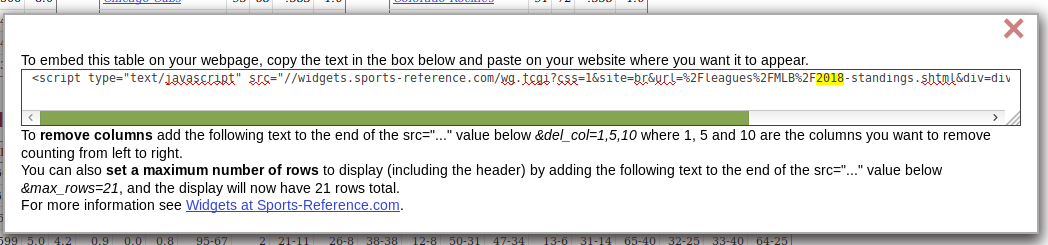

Typically in this url you will see a year(or some other variable) that you can change to get that year's version of the table that you are looking at.

The rest of this code shows you how to scrape the detail standings data for years 1980 through 2018. The big assumption here is that you are comfortable with, or are willing to put in the effort yourself to learn, python.

Feel free to adapt it to your needs.

In [3]:
url = "http://widgets.sports-reference.com/wg.fcgi?css=1&site=br&url=%2Fleagues%2FMLB%2F{}-standings.shtml&div=div_expanded_standings_overall"

In [5]:
#put all the years together
all_years_df = pd.concat(all_years)
all_years_df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,1Run,<.500,ExInn,G,Home,Inter,L,Lg,Luck,R,...,W,W-L%,pythWL,vCent,vEast,vLHP,vRHP,vWest,year,≥.500
0,30-20,59-27,10-9,162.0,53-28,NaN,59,AL,6.0,5.1,...,103,0.636,97-65,NaN,50-28,41-27,62-32,53-31,1980,44-32
1,28-23,55-31,6-6,162.0,50-31,NaN,62,AL,2.0,5.0,...,100,0.617,98-64,NaN,49-29,35-23,65-39,51-33,1980,45-31
2,29-12,54-35,8-6,162.0,49-32,NaN,65,AL,5.0,5.0,...,97,0.599,92-70,NaN,53-31,37-28,60-37,44-34,1980,43-30
3,33-27,48-24,9-7,163.0,55-26,NaN,70,NL,6.0,3.9,...,93,0.571,87-76,NaN,41-31,32-25,61-45,52-39,1980,45-46
4,31-33,43-29,10-9,163.0,55-27,NaN,71,NL,2.0,4.1,...,92,0.564,90-73,NaN,44-28,16-8,76-63,48-43,1980,49-42


## Functions

In [43]:

## This is the best place to get started.
## This function simply takes a url and provides the ids
## from the html tables that the code provided here can access.
## Using findTables is great for determining options for the
## pullTable function for the tableID argument.
def findTables(url):
    res = requests.get(url)
    ## The next two lines get around the issue with comments breaking the parsing.
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    divs = soup.findAll('div', id = "content")
    divs = divs[0].findAll("div", id=re.compile("^all"))
    ids = []
    for div in divs:
        searchme = str(div.findAll("table"))
        x = searchme[searchme.find("id=") + 3: searchme.find(">")]
        x = x.replace("\"", "")
        if len(x) > 0:
            ids.append(x)
    return(ids)
## For example:
## findTables("http://www.baseball-reference.com/teams/KCR/2016.shtml")


## Pulls a single table from a url provided by the user.
## The desired table should be specified by tableID.
## This function is used in all functions that do more complicated pulls.
def pullTable(url, tableID):
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    tables = soup.findAll('table', id = tableID)
    data_rows = tables[0].findAll('tr')
    data_header = tables[0].findAll('thead')
    data_header = data_header[0].findAll("tr")
    data_header = data_header[0].findAll("th")
    game_data = [[td.getText() for td in data_rows[i].findAll(['th','td'])]
        for i in range(len(data_rows))
        ]
    data = pd.DataFrame(game_data)
    header = []
    for i in range(len(data.columns)):
        header.append(data_header[i].getText())
    data.columns = header
    data = data.loc[data[header[0]] != header[0]]
    data = data.reset_index(drop = True)
    return(data)

def pullBoxscoreTable(url, tableID):
    print(url)
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    
#     details = soup.find("div", {"id": "div_9431722041"})
#     dtext = details.text.strip(' \t\n\r').split('\n')
#     first = dtext[0].split('.Time of ')


    # Get other info section
    dtext = []
    
    for div in soup.find_all('div', attrs={'class': 'section_content'}):
        inner_text = div.text.strip()
        if 'Umpires' in inner_text:
            dtext = inner_text.strip(' \t\n\r').replace('Umpires:', '?').replace('Time of Game:', '?').replace('Attendance:', '?').replace('Field Condition:', '?').replace('Start Time Weather:', '?Weather:')
            dtext = dtext.split('?')
            break
            
    detailDict = {}
    meta = soup.find("div", {"class": "scorebox_meta"})
    meta = meta.text.strip(' \t\n\r').replace('Start Time:', '?Start Time:').replace('Attendance:', '?Attendance').replace('Venue:', '?Venue:').replace('Game Duration:', '?Game Duration:').replace(', on', '?')
    mtext = meta.split('?')
    
    start_time = ''
    grass = ''
    stadium = ''
    
    for info in mtext:
        info = info.strip(' \t\n\r')
        if info:
            if 'Start Time' in info:
                start_time = info.replace('Start Time: ', '').strip(' \t\n\r')
            elif 'Venue' in info:
                stadium = info.replace('Venue: ', '').strip(' \t\n\r')
            elif 'turf' in info:
                grass = 'turf'
            elif 'grass' in info:
                grass = 'grass'
            
#     ['Thursday, March 28, 2019', ' Time: 1:05 p.m. ETAttendance: 42,263', ' Nationals Park', ' Duration: 2:44Day ', ', on grassVideo of game on MLB.com\nLogos via Sports Logos.net\n            / About logos']
    
    detailDict['start_time'] = start_time.strip()
    detailDict['stadium'] = stadium.strip()
    detailDict['turf'] = grass.strip()
    
#     ['Umpires: HP - Sam Holbrook, 1B - Ryan Additon, 2B - Manny Gonzalez, 3B - Dan Iassogna', 'Time of Game: 2:37', '\nAttendance: 26,945', '\nStart Time Weather: 74° F, Wind 0mph, In Dome', '']
    for info in dtext:
        info = info.strip(' \t\n\r').strip('.')
        if info:
            if '1B' in info:
                umps = info.strip(' \t\n\r').split(',')
                bases = ['HP', '1B', '2B', '3B']

                for i in range(len(umps)):
                    ump_name = umps[i].strip(' \t\n\r').split('-')[1].strip(' \t\n\r').split('.Time')[0]
                    detailDict[('umpire-' + bases[i])] = ump_name
            elif 'Weather' in info:
                weather_info = info.replace('Weather: ', '').strip(' \t\n\r').split(',')
                temperature = weather_info[0].strip(' \t\n\r')
                wind = weather_info[1].strip(' \t\n\r').replace('Wind ', '')
                weather = ''
                
                # Check if more weather info
                if (len(weather_info) > 2):
   
                    if 'Dome' in weather_info[2]:
                        weather = 'In Dome'
                    else:
                        weather = weather_info[2]
                else:
                    weather = 'Normal'
                    
                detailDict['wind'] = wind.strip()
                detailDict['weather'] = weather.strip()
                detailDict['temperature'] = temperature.strip()
                
    return(detailDict)
## For example:
## url = "http://www.baseball-reference.com/teams/KCR/2016.shtml"
## pullTable(url, "team_batting")



## Pulls game level data for team and year provided.
## The team provided must be a three-character abbreviation:
## 'ATL', 'ARI', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET',
## 'KCR', 'HOU', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK',
## 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN'
def pullGameData(team, year):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + "-schedule-scores.shtml"
    ## Let's funnel this work into the pullTable function
    dat = pullTable(url, "team_schedule")
    dates = dat["Date"]
    ndates = []
    for d in dates:
        month = d.split(" ")[1]
        day = d.split(" ")[2]
        day = day.zfill(2)
        mapping = {"Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08",
                   "Sep": "09", "Oct": "10", "Nov":"11"}
        m = mapping[month]
        ndates.append(str(year) + m + day)
    uni, counts = np.unique(ndates, return_counts = True)
    ndates = []
    for t in range(len(counts)):
        ux = uni[t]
        cx = counts[t]
        if cx == 1:
            ndates.append(ux + "0")
        else:
            for i in range(int(cx)):
                ii = i + 1
                ndates.append(ux + str(ii))
    dat["Date"] = ndates
    dat.rename(columns = {dat.columns[4] : "Location"}, inplace = True)
    homegame = []
    for g in dat["Location"]:
        homegame.append(g == "")
    dat["HomeGame"] = homegame
        
    ump_hp = []
    ump_1 = []
    ump_2 = []
    ump_3 = []
    start_time = []
    wind = []
    weather = []
    temperature = []
    stadium = []
    turf = []

    currentInfo = None
    for index, row in dat.iterrows():
        try:
            gameinfo = gameOtherInfoFinder(row)
            currentInfo = gameinfo
#             {'start_time': '1:07 p.m. Local', 'stadium': 'Oakland-Alameda County Coliseum', 'turf': 'on grass', 'umpire-HP': 'Brian Gorman', 'umpire-1B': 'Mark Carlson', 'umpire-2B': 'Mike DiMuro', 'umpire-3B': 'Quinn Wolcott', 'wind': '5mph out to Rightfield', 'weather': 'Sunny', 'temperature': '70° F'}
            ump_hp.append(gameinfo['umpire-HP'])
            ump_1.append(gameinfo['umpire-1B'])
            ump_2.append(gameinfo['umpire-2B'])
            ump_3.append(gameinfo['umpire-3B'])

            start_time.append(gameinfo['start_time'])

            wind.append(gameinfo['wind'])
            temperature.append(gameinfo['temperature'])

            weather.append(gameinfo['weather'])
            stadium.append(gameinfo['stadium'])

            turf.append(gameinfo['turf'])
          
        # Figure out which index used above is causing error
        except:
            print('error in ', index)
            e = sys.exc_info()[0]
            print(row)
            print('error: ', e)
            break
            pass
       
    
    dat['umpire-HP'] = ump_hp
    dat['umpire-1B'] = ump_1
    dat['umpire-2B'] = ump_2
    dat['umpire-3B'] = ump_3
#     dat['time_of_day']
    dat['temperature'] = temperature
    dat['wind'] = wind
    dat['weather'] = weather
    dat['start_time'] = start_time
    dat['stadium'] = stadium
    dat['turf'] = turf

    return(dat)


## Pulls data summarizing the season performance of all players on the
## team provided for the given year.
## The table type argument must be one of five possibilities:
## "team_batting"
## "team_pitching"
## "standard_fielding"
## "players_value_batting"
## "players_value_pitching"
def pullPlayerData (team, year, tabletype):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + ".shtml"
    data = pullTable(url, tabletype)
    data = data[data.Name.notnull()]
    data = data.reset_index(drop = True)
    names = data.columns
    for c in range(0, len(names)):
        replacement = []
        if type (data.loc[0][c]) == str:
            k = names[c]
            for i in range(0, len(data[k])):
                p = data.loc[i][c]
                xx = re.sub("[#@*&^%$!]", "", p)
                xx = xx.replace("\xa0", "_")
                xx = xx.replace(" ", "_")
                replacement.append(xx)
            data[k] = replacement
    data["Team"] = team
    data["Year"] = year
    return(data)


## This is used later to append integers to games on the same date to
## separate them.
def Quantify (x):
    out = []
    for i in x:
        if len(i) < 1:
            out.append(None)
        else:
            out.append(float(i))
    return(out)


## Pulls box score data from a game provided in the gameInfo input
## This is meant to be run by the pullBoxScores function below.

def gameOtherInfoFinder(gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    battingNames = {"ATL":"AtlantaBravesbatting",
                    "ARI":"ArizonaDiamondbacksbatting",
                    "BAL":"BaltimoreOriolesbatting",
                    "BOS":"BostonRedSoxbatting",
                    "CHC":"ChicagoCubsbatting",
                    "CHW":"ChicagoWhiteSoxbatting",
                    "CIN":"CincinnatiRedsbatting",
                    "CLE":"ClevelandIndiansbatting",
                    "COL":"ColoradoRockiesbatting",
                    "DET":"DetroitTigersbatting",
                    "KCR":"KansasCityRoyalsbatting",
                    "HOU":"HoustonAstrosbatting",
                    "LAA":"AnaheimAngelsbatting",
                    "LAD":"LosAngelesDodgersbatting",
                    "MIA":"MiamiMarlinsbatting",
                    "MIL":"MilwaukeeBrewersbatting",
                    "MIN":"MinnesotaTwinsbatting",
                    "NYM":"NewYorkMetsbatting",
                    "NYY":"NewYorkYankeesbatting",
                    "OAK":"OaklandAthleticsbatting",
                    "PHI":"PhiladelphiaPhilliesbatting",
                    "PIT":"PittsburghPiratesbatting",
                    "SDP":"SanDiegoPadresbatting",
                    "SEA":"SeattleMarinersbatting",
                    "SFG":"SanFranciscoGiantsbatting",
                    "STL":"StLouisCardinalsbatting",
                    "TBR":"TampaBayRaysbatting",
                    "TEX":"TexasRangersbatting",
                    "TOR":"TorontoBlueJaysbatting",
                    "WSN":"WashingtonNationalsbatting"}
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == False:
        opp = gameInfo["Opp"]
        if opp in teamNames:
            opp = teamNames[opp]
        url = "http://www.baseball-reference.com/boxes/" + opp + "/" + opp + str(date) + ".shtml"
    else:
        team = gameInfo["Tm"]
        if team in teamNames:
            team = teamNames[team]
        url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    battingInfo = battingNames[gameInfo["Tm"]]
    data = pullBoxscoreTable(url, battingInfo)
    return(data)


def gameFinder (gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    battingNames = {"ATL":"AtlantaBravesbatting",
                    "ARI":"ArizonaDiamondbacksbatting",
                    "BAL":"BaltimoreOriolesbatting",
                    "BOS":"BostonRedSoxbatting",
                    "CHC":"ChicagoCubsbatting",
                    "CHW":"ChicagoWhiteSoxbatting",
                    "CIN":"CincinnatiRedsbatting",
                    "CLE":"ClevelandIndiansbatting",
                    "COL":"ColoradoRockiesbatting",
                    "DET":"DetroitTigersbatting",
                    "KCR":"KansasCityRoyalsbatting",
                    "HOU":"HoustonAstrosbatting",
                    "LAA":"AnaheimAngelsbatting",
                    "LAD":"LosAngelesDodgersbatting",
                    "MIA":"MiamiMarlinsbatting",
                    "MIL":"MilwaukeeBrewersbatting",
                    "MIN":"MinnesotaTwinsbatting",
                    "NYM":"NewYorkMetsbatting",
                    "NYY":"NewYorkYankeesbatting",
                    "OAK":"OaklandAthleticsbatting",
                    "PHI":"PhiladelphiaPhilliesbatting",
                    "PIT":"PittsburghPiratesbatting",
                    "SDP":"SanDiegoPadresbatting",
                    "SEA":"SeattleMarinersbatting",
                    "SFG":"SanFranciscoGiantsbatting",
                    "STL":"StLouisCardinalsbatting",
                    "TBR":"TampaBayRaysbatting",
                    "TEX":"TexasRangersbatting",
                    "TOR":"TorontoBlueJaysbatting",
                    "WSN":"WashingtonNationalsbatting"}
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == False:
        opp = gameInfo["Opp"]
        if opp in teamNames:
            opp = teamNames[opp]
        url = "http://www.baseball-reference.com/boxes/" + opp + "/" + opp + str(date) + ".shtml"
    else:
        team = gameInfo["Tm"]
        if team in teamNames:
            team = teamNames[team]
        url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    battingInfo = battingNames[gameInfo["Tm"]]
    data = pullTable(url, battingInfo)
    names = []
    for i in data["Batting"]:
        if len(i) > 0:
            xx = (i.split(" ")[0] + "_" + i.split(" ")[1])
            xx = xx.replace("\xa0", "")
            names.append(xx)
        else:
            names.append("NA")
    data["Name"] = names
    data["Date"] = date
    data["HomeGame"] = home
    data = data[data.Name != "NA"]
    for d in data:
        if d not in ["Batting", "Name", "Details", "Date", "HomeGame"]:
            tmp = Quantify(data[d])
            data[d] = tmp
    data = data[data["AB"] > 0]
    return(data)


## Pulls all of the boxscores for a team in a given year.
## The directory argument is used to specify where to save the .csv
## If overwrite is True, an existing file with the same name will be overwritten.
def pullBoxscores (team, year, directory, overwrite = True):
    if not os.path.exists(directory):
        os.makedirs(directory)
    if overwrite == False:
        if os.path.exists(directory + team + ".csv"):
            return("This already exists!")
    dat = pullGameData(team, year)
    DatDict = dict()
    for r in range(len(dat)):
        inputs = dat.loc[r]
        try:
            DatDict[r] = gameFinder(inputs)
        except IndexError:
            pass
    playerGameData = pd.concat(DatDict)
    playerGameData.reset_index(inplace = True)
    playerGameData = playerGameData.rename(columns = {"level_0": "Game", "level_1": "BatPos"})
    playerGameData.to_csv(directory + team + "_" + str(year) + ".csv")


## This is an internal function to pullPlaybyPlay
def PlayByPlay (gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    oteam = gameInfo["Tm"]
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == 0:
        team = gameInfo["Opp"]
        opp = gameInfo["Tm"]
        if opp in teamNames:
            opp = teamNames[opp]
    else:
        team = gameInfo["Tm"]
        opp = gameInfo["Opp"]
        if team in teamNames:
            team = teamNames[team]
    url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    dat = pullTable(url, "play_by_play")
    dat = dat.loc[dat["Batter"].notnull()]
    dat = dat.loc[dat["Play Description"].notnull()]
    dat["Date"] = date
    dat["Hteam"] = team
    dat["Ateam"] = opp
    pteam = []
    pteams = np.unique(dat["@Bat"])
    for d in dat["@Bat"]:
        if d == pteams[0]:
            pteam.append(pteams[1])
        else:
            pteam.append(pteams[0])
    dat["Pteam"] = pteam
    if gameInfo["R"] > gameInfo["RA"]:
        winner = oteam
    else:
        winner = gameInfo["Opp"]
    dat["Winner"] = winner
    return(dat)


## Pulls all of the play by play tables for a team for a given year.
## Output is the name of the .csv file you want to save.  I force a
## file to be saved here because the function takes a while to run.
def pullPlaybyPlay (team, year, output, check = False):
    dat = pullGameData(team, year)
    dat = dat[dat.Time == dat.Time] ## Only pull games that have ended
    if check:
        olddat = pd.read_csv(output)
        dates = np.unique(olddat.Date)
        mostrecent = np.max(dates)
        dat.Date = dat.Date.astype("int")
        dat = dat.loc[dat.Date > mostrecent]
        dat.reset_index(inplace = True)
        dat = dat.loc[dat.Time == dat.Time]
    DatDict = dict()
    for r in range(len(dat)):
        inputs = dat.loc[r]
        try:
            DatDict[r] = PlayByPlay(inputs)
        except IndexError:
            pass
    if len(DatDict) == 0:
        return("No new games to be added!")
    bdat = pd.concat(DatDict)
    bdat["Hteam"] = team
    names = []
    for i in bdat["Batter"]:
        if len(i) > 0:
            xx = i
            xx = xx.replace("\xa0", "")
            names.append(xx)
        else:
            names.append("NA")
    bdat["BatterName"] = names
    ## These rules attempt to sort out different play outcomes by
    ## searching the text in the "Play Description" variable.
    bdat["out"] = (bdat["Play Description"].str.contains("out")) | (bdat["Play Description"].str.contains("Play")) | (bdat["Play Description"].str.contains("Flyball")) | (bdat["Play Description"].str.contains("Popfly"))
    bdat["hbp"] = bdat["Play Description"].str.startswith("Hit")
    bdat["walk"] = (bdat["Play Description"].str.contains("Walk"))
    bdat["stolenB"] = bdat["Play Description"].str.contains("Steal")
    bdat["wild"] = bdat["Play Description"].str.startswith("Wild") | bdat["Play Description"].str.contains("Passed")
    bdat["error"] = bdat["Play Description"].str.contains("Reached on")
    bdat["pick"] = bdat["Play Description"].str.contains("Picked")
    bdat["balk"] = bdat["Play Description"].str.contains("Balk")
    bdat["interference"] = bdat["Play Description"].str.contains("Reached on Interference")
    bdat["sacrifice"] = bdat["Play Description"].str.contains("Sacrifice")
    bdat["ab"] = (bdat["walk"] == False) & (bdat["sacrifice"] == False) & (bdat["interference"] == False) & (bdat["stolenB"] == False) & (bdat["wild"] == False) & (bdat["hbp"] == False) & (bdat["pick"] == False) & (bdat["balk"] == False)
    bdat["hit"] =  (bdat["walk"] == False) & (bdat["out"] == False) & (bdat["stolenB"] == False) & (bdat["error"] == False) & (bdat["ab"] == True)
    if check:
        if len(olddat) > 0:
            bdat = olddat.append(bdat)
            bdat.reset_index(inplace = True, drop = True)
    bdat.to_csv(output)
    return(bdat)


## This pulls information about which hand a pitcher throws with.  I
## made this solely to allow pitcher handedness to be used as a
## variable in models.
def pullPitcherData (team, year):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + ".shtml"
    data = pullTable(url, "team_pitching")
    data = data[data.Name.notnull()]
    data = data[data.Rk.notnull()]
    data = data[data.G != "162"]
    data = data.reset_index(drop = True)
    data["Team"] = team
    data["Year"] = year
    data["LeftHanded"] = data["Name"].str.contains("\\*")
    names = data.columns
    for c in range(0, len(names)):
        replacement = []
        if type (data.loc[0][c]) == str:
            k = names[c]
            for i in range(0, len(data[k])):
                p = data.loc[i][c]
                xx = re.sub("[#@&*^%$!]", "", p)
                xx = xx.replace("\xa0", "_")
                xx = xx.replace(" ", "_")
                replacement.append(xx)
            data[k] = replacement
    data = data[["Name", "LeftHanded", "Team", "Year"]]
    return(data)



def YearData(yr, directory):
    year = str(yr)

    if not os.path.exists(directory):
        os.makedirs(directory)

    dataBase = dict()

    teams = ['ATL', 'ARI', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET',
             'KCR', 'HOU', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK',
             'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN']

#     teams = ['NYM']
    for tm in teams:
        try:
            dataBase[tm] = pullGameData(tm, year)
        except IndexError:
            pass

    gameData = pd.concat(dataBase)

    gameData.rename(columns = {"Tm" :"HomeTeam", 
                               "Opp":"AwayTeam", 
                               "Record":"HomeRecord",
                               "Runs":"R", 
                               "OppRuns":"RA",  
                               "W-L":"HomeWL",  
                               "Streak":"HomeStreak"}, inplace = True)
   
    gameData = gameData.sort_values(["Date"])

    #gameData = gameData.drop("gamenum", axis = 1)
    #gameData = gameData.drop("gamenum2", axis = 1)
    #gameData = gameData.drop("boxscore", axis = 1)

    homeData = gameData[gameData["Location"] != "@"]

    homeData = homeData.drop("Location", axis = 1)

    homeData["Index"] = range(0, len(homeData))

    outfile = directory + year + "Games.csv"

    homeData["year"] = year

    homeData.to_csv(outfile, index = False, encoding = "utf-8")
    return(homeData)

## Now the function is defined, use it
    

In [44]:
YearData(2019, './')
YearData(2018, './')
YearData(2017, './')
YearData(2016, './')


http://www.baseball-reference.com/boxes/PHI/PHI201903280.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201903300.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201903310.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904010.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904030.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904040.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904050.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904060.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904070.shtml
http://www.baseball-reference.com/boxes/COL/COL201904080.shtml
http://www.baseball-reference.com/boxes/COL/COL201904090.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904110.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904120.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904130.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904140.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20190416

http://www.baseball-reference.com/boxes/NYN/NYN201908250.shtml
http://www.baseball-reference.com/boxes/COL/COL201908260.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201908270.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201908280.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908300.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908310.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909010.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909020.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909030.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909050.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909060.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909070.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909080.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909090.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909100.shtml
http://www.baseball-reference.com/boxes/PHI/PHI20190911

http://www.baseball-reference.com/boxes/ARI/ARI201907220.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201907230.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201907240.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907260.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907270.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907290.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907300.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907310.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908020.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908030.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908040.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908050.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908060.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908070.shtml
http://www.baseball-reference.com/boxes/LAN/LAN20190809

http://www.baseball-reference.com/boxes/BAL/BAL201906150.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906160.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906170.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906180.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906190.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906200.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906210.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906220.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906230.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906250.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906260.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906280.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906290.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906300.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907010.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20190702

http://www.baseball-reference.com/boxes/BOS/BOS201905100.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905110.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905120.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905140.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905150.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905170.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905180.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905190.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905200.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905210.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905220.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905230.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905240.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905250.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS20190527

http://www.baseball-reference.com/boxes/MIL/MIL201904060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201904070.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904080.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904100.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904110.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904120.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904130.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904150.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904160.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904170.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904190.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904200.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904210.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904230.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904240.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20190425

http://www.baseball-reference.com/boxes/MIL/MIL201909050.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201909060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201909070.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201909080.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909090.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909100.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909110.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909120.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909130.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909160.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909170.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909180.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909190.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20190920

http://www.baseball-reference.com/boxes/PHI/PHI201908030.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908040.shtml
http://www.baseball-reference.com/boxes/DET/DET201908050.shtml
http://www.baseball-reference.com/boxes/DET/DET201908061.shtml
http://www.baseball-reference.com/boxes/DET/DET201908062.shtml
http://www.baseball-reference.com/boxes/DET/DET201908070.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908090.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908100.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908110.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908131.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908132.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908140.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908150.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908160.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908170.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20190818

http://www.baseball-reference.com/boxes/ANA/ANA201906260.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906280.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906290.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906300.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907010.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907020.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907030.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907040.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907060.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907070.shtml
http://www.baseball-reference.com/boxes/COL/COL201907120.shtml
http://www.baseball-reference.com/boxes/COL/COL201907130.shtml
http://www.baseball-reference.com/boxes/COL/COL201907140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201907150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201907160.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20190717

http://www.baseball-reference.com/boxes/CLE/CLE201905210.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905220.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905230.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905240.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905250.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905270.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905280.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905290.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201905300.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201905310.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201906010.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201906020.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201906040.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201906050.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20190606

http://www.baseball-reference.com/boxes/SFN/SFN201904140.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201904150.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201904160.shtml
http://www.baseball-reference.com/boxes/COL/COL201904180.shtml
http://www.baseball-reference.com/boxes/COL/COL201904190.shtml
http://www.baseball-reference.com/boxes/COL/COL201904200.shtml
http://www.baseball-reference.com/boxes/COL/COL201904210.shtml
http://www.baseball-reference.com/boxes/COL/COL201904220.shtml
http://www.baseball-reference.com/boxes/COL/COL201904230.shtml
http://www.baseball-reference.com/boxes/COL/COL201904240.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904260.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904270.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904280.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201904290.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201904300.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20190501

http://www.baseball-reference.com/boxes/COL/COL201909120.shtml
http://www.baseball-reference.com/boxes/COL/COL201909130.shtml
http://www.baseball-reference.com/boxes/COL/COL201909140.shtml
http://www.baseball-reference.com/boxes/COL/COL201909150.shtml
http://www.baseball-reference.com/boxes/COL/COL201909160.shtml
http://www.baseball-reference.com/boxes/COL/COL201909170.shtml
http://www.baseball-reference.com/boxes/COL/COL201909180.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201909200.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201909210.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201909220.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909240.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909250.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909260.shtml
http://www.baseball-reference.com/boxes/COL/COL201909270.shtml
http://www.baseball-reference.com/boxes/COL/COL201909280.shtml
http://www.baseball-reference.com/boxes/COL/COL20190929

http://www.baseball-reference.com/boxes/DET/DET201908110.shtml
http://www.baseball-reference.com/boxes/DET/DET201908130.shtml
http://www.baseball-reference.com/boxes/DET/DET201908140.shtml
http://www.baseball-reference.com/boxes/DET/DET201908150.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908160.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908170.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908180.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201908190.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201908200.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201908210.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201908220.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201908230.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201908240.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201908250.shtml
http://www.baseball-reference.com/boxes/DET/DET201908270.shtml
http://www.baseball-reference.com/boxes/DET/DET20190828

http://www.baseball-reference.com/boxes/KCA/KCA201907020.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907030.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907040.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907050.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907060.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907070.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907120.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907130.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907140.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907150.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907160.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907170.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907180.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201907190.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201907200.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20190721

http://www.baseball-reference.com/boxes/HOU/HOU201905270.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905280.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905290.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905310.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906010.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906020.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906030.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906040.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906050.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906060.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906070.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906080.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906090.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906110.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906120.shtml
http://www.baseball-reference.com/boxes/HOU/HOU20190614

http://www.baseball-reference.com/boxes/ANA/ANA201904230.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904240.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904250.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201904260.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201904270.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201904280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904300.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905010.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905020.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905040.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905050.shtml
http://www.baseball-reference.com/boxes/DET/DET201905070.shtml
http://www.baseball-reference.com/boxes/DET/DET201905080.shtml
http://www.baseball-reference.com/boxes/DET/DET201905090.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905100.shtml
http://www.baseball-reference.com/boxes/BAL/BAL20190511

http://www.baseball-reference.com/boxes/HOU/HOU201909210.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201909220.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909240.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909250.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909260.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909270.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909290.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201903280.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201903290.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201903300.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201903310.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201904010.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201904020.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201904030.shtml
http://www.baseball-reference.com/boxes/COL/COL20190405

http://www.baseball-reference.com/boxes/ATL/ATL201908160.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908170.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908180.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908200.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908210.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908220.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908230.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908240.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908250.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908260.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908270.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908280.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908290.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908300.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908310.shtml
http://www.baseball-reference.com/boxes/ARI/ARI20190901

http://www.baseball-reference.com/boxes/MIA/MIA201907170.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907180.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907190.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907200.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907210.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907220.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907230.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907240.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907260.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907270.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907310.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201908010.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20190803

http://www.baseball-reference.com/boxes/MIL/MIL201906050.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906070.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906080.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906090.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906110.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906120.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201906140.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201906150.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201906160.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201906170.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201906180.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201906190.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906200.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906210.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20190622

http://www.baseball-reference.com/boxes/NYA/NYA201905040.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201905050.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905060.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905070.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905080.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905100.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905111.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905112.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905120.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905130.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905140.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905150.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905160.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905170.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905180.shtml
http://www.baseball-reference.com/boxes/SEA/SEA20190519

http://www.baseball-reference.com/boxes/KCA/KCA201909290.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201903280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201903300.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201903310.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904010.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904020.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904030.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904040.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904060.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904070.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904090.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904100.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904110.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904120.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904130.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20190414

http://www.baseball-reference.com/boxes/NYN/NYN201908270.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908280.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908290.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908300.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908310.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909010.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909020.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909030.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909040.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201909060.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201909070.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201909080.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201909090.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201909100.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201909110.shtml
http://www.baseball-reference.com/boxes/NYN/NYN20190912

http://www.baseball-reference.com/boxes/MIN/MIN201907230.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201907240.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201907250.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201907260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201907270.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201907280.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907300.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907310.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201908020.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201908031.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201908032.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201908040.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201908050.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201908060.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201908070.shtml
http://www.baseball-reference.com/boxes/TOR/TOR20190808

http://www.baseball-reference.com/boxes/TBA/TBA201906110.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201906120.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906140.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906150.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906160.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906170.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906180.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906190.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906200.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906210.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906220.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906230.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906250.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906260.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201906270.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20190628

http://www.baseball-reference.com/boxes/KCA/KCA201905110.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201905120.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905130.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905140.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905150.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905160.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905170.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905180.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905190.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905200.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905210.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905220.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905230.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905240.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905250.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20190526

http://www.baseball-reference.com/boxes/PIT/PIT201904060.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904070.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904080.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904100.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904110.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904120.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904130.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904140.shtml
http://www.baseball-reference.com/boxes/DET/DET201904160.shtml
http://www.baseball-reference.com/boxes/DET/DET201904170.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904200.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904210.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904220.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904230.shtml
http://www.baseball-reference.com/boxes/PIT/PIT20190424

http://www.baseball-reference.com/boxes/PIT/PIT201909030.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201909040.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201909050.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201909060.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201909070.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201909080.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909090.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909100.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909110.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909120.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909130.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909150.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201909170.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201909180.shtml
http://www.baseball-reference.com/boxes/PIT/PIT20190919

http://www.baseball-reference.com/boxes/SDN/SDN201907300.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908010.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908020.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908030.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201908040.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201908060.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201908070.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908080.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908090.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908100.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908110.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908120.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908130.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908140.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908160.shtml
http://www.baseball-reference.com/boxes/PHI/PHI20190817

http://www.baseball-reference.com/boxes/SEA/SEA201906170.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906180.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906190.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906200.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906210.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906220.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906230.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906250.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906260.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201906270.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906280.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906290.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201906300.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201907020.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201907030.shtml
http://www.baseball-reference.com/boxes/SEA/SEA20190704

http://www.baseball-reference.com/boxes/ARI/ARI201905190.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905200.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905210.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905220.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905230.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905240.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905250.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905260.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201905280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201905290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201905300.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905310.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906010.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906020.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201906040.shtml
http://www.baseball-reference.com/boxes/NYN/NYN20190605

http://www.baseball-reference.com/boxes/CIN/CIN201904130.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201904140.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201904150.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201904160.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201904170.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904190.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904200.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904210.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904220.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904230.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904240.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904260.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904270.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201904280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904290.shtml
http://www.baseball-reference.com/boxes/WAS/WAS20190430

http://www.baseball-reference.com/boxes/COL/COL201909110.shtml
http://www.baseball-reference.com/boxes/COL/COL201909120.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201909130.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201909140.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201909150.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201909160.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201909170.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201909180.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909190.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909200.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909210.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909220.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201909230.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201909240.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201909250.shtml
http://www.baseball-reference.com/boxes/SLN/SLN20190927

http://www.baseball-reference.com/boxes/TBA/TBA201908050.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908060.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908070.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201908090.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201908100.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201908110.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908120.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908130.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201908140.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908160.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908170.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908180.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908190.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908200.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201908210.shtml
http://www.baseball-reference.com/boxes/BAL/BAL20190822

http://www.baseball-reference.com/boxes/TBA/TBA201906290.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201906300.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907020.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907030.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907040.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201907050.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201907060.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201907070.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907110.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907120.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907130.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907140.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907160.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201907170.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201907190.shtml
http://www.baseball-reference.com/boxes/HOU/HOU20190720

http://www.baseball-reference.com/boxes/TOR/TOR201905250.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905260.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201905270.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201905280.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201905290.shtml
http://www.baseball-reference.com/boxes/COL/COL201905310.shtml
http://www.baseball-reference.com/boxes/COL/COL201906010.shtml
http://www.baseball-reference.com/boxes/COL/COL201906020.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201906040.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201906050.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201906060.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201906070.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201906080.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201906090.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906110.shtml
http://www.baseball-reference.com/boxes/BAL/BAL20190612

http://www.baseball-reference.com/boxes/COL/COL201904220.shtml
http://www.baseball-reference.com/boxes/COL/COL201904230.shtml
http://www.baseball-reference.com/boxes/COL/COL201904240.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904260.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904270.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904290.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904300.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201905010.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201905020.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905030.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905040.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905050.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905070.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20190508

http://www.baseball-reference.com/boxes/MIA/MIA201909200.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201909210.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201909220.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909230.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909241.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909242.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909250.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909260.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909270.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909290.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201803290.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201803300.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201803310.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201804020.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20180403

ValueError: Length of values does not match length of index

In [ ]:
# url = "http://www.baseball-reference.com/teams/KCR/2016.shtml"
temp = pullTable(url, "team_pitching")

In [47]:
temp.dtypes

Rk      object
Pos     object
Name    object
Age     object
W       object
L       object
W-L%    object
ERA     object
G       object
GS      object
GF      object
CG      object
SHO     object
SV      object
IP      object
H       object
R       object
ER      object
HR      object
BB      object
IBB     object
SO      object
HBP     object
BK      object
WP      object
BF      object
ERA+    object
FIP     object
WHIP    object
H9      object
HR9     object
BB9     object
SO9     object
SO/W    object
dtype: object

In [36]:
pullPlaybyPlay('KCR', 2016, 'LOVE.CSV', check = False)

pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201604030.shtml
weather info:  ['74° F', ' Wind 14mph from Right to Left', ' Sunny']
got detailDict:  {'start_time': '7:38 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Gerry Davis', 'umpire-1B': 'Sam Holbrook', 'umpire-2B': 'Rob Drake', 'umpire-3B': 'Carlos Torres', 'wind': '14mph from Right to Left', 'weather': 'Sunny', 'temperature': '74° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201604050.shtml
weather info:  ['68° F', ' Wind 17mph from Right to Left', ' Sunny']
got detailDict:  {'start_time': '3:16 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Sam Holbrook', 'umpire-1B': 'Rob Drake', 'umpire-2B': 'Carlos Torres', 'umpire-3B': 'Gerry Davis', 'wind': '17mph from Right to Left', 'weather': 'Sunny', 'temperature': '68° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201604080.sh

weather info:  ['60° F', ' Wind 6mph out to Centerfield']
got detailDict:  {'start_time': '7:08 p.m. Local', 'stadium': 'Angel Stadium of Anaheim', 'turf': 'on grass', 'umpire-HP': 'Jordan Baker', 'umpire-1B': 'Mike Everitt', 'umpire-2B': 'Tim Timmons', 'umpire-3B': 'Toby Basner', 'wind': '6mph out to Centerfield', 'weather': 'Normal', 'temperature': '60° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/ANA/ANA201604260.shtml
weather info:  ['66° F', ' Wind 7mph out to Centerfield', ' Cloudy']
got detailDict:  {'start_time': '7:09 p.m. Local', 'stadium': 'Angel Stadium of Anaheim', 'turf': 'on grass', 'umpire-HP': 'Mike Everitt', 'umpire-1B': 'Tim Timmons', 'umpire-2B': 'Toby Basner', 'umpire-3B': 'Jordan Baker', 'wind': '7mph out to Centerfield', 'weather': 'Cloudy', 'temperature': '66° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/ANA/ANA201604270.shtml
weather info:  ['63° F', ' Wind 9mph from Right to Left', ' Sunny']
got det

weather info:  ['66° F', ' Wind 3mph from Left to Right', ' Cloudy']
got detailDict:  {'start_time': '1:18 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Mike Estabrook', 'umpire-1B': 'Jordan Baker', 'umpire-2B': 'Greg Gibson', 'umpire-3B': 'Ed Hickox', 'wind': '3mph from Left to Right', 'weather': 'Cloudy', 'temperature': '66° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201605170.shtml
weather info:  ['58° F', ' Wind 10mph in from Rightfield', ' Cloudy']
got detailDict:  {'start_time': '7:15 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Bill Miller', 'umpire-1B': 'Brian Knight', 'umpire-2B': 'Pat Hoberg', 'umpire-3B': 'Todd Tichenor', 'wind': '10mph in from Rightfield', 'weather': 'Cloudy', 'temperature': '58° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201605181.shtml
weather info:  ['65° F', ' Wind 4mph in from Rightfield', ' Cloudy']
got detai

weather info:  ['72° F', ' Wind 6mph out to Leftfield', ' Overcast']
got detailDict:  {'start_time': '7:47 p.m. Local', 'stadium': 'Progressive Field', 'turf': 'on grass', 'umpire-HP': 'Sam Holbrook', 'umpire-1B': 'Gerry Davis', 'umpire-2B': 'Rob Drake', 'umpire-3B': 'Carlos Torres', 'wind': '6mph out to Leftfield', 'weather': 'Overcast', 'temperature': '72° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/CLE/CLE201606050.shtml
weather info:  ['78° F', ' Wind 13mph out to Rightfield', ' Cloudy']
got detailDict:  {'start_time': '1:10 p.m. Local', 'stadium': 'Progressive Field', 'turf': 'on grass', 'umpire-HP': 'Gerry Davis', 'umpire-1B': 'Rob Drake', 'umpire-2B': 'Carlos Torres', 'umpire-3B': 'Sam Holbrook', 'wind': '13mph out to Rightfield', 'weather': 'Cloudy', 'temperature': '78° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/BAL/BAL201606060.shtml
weather info:  ['83° F', ' Wind 4mph out to Centerfield', ' Cloudy']
got detailD

weather info:  ['93° F', ' Wind 17mph from Right to Left', ' Sunny']
got detailDict:  {'start_time': '6:16 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Mark Ripperger', 'umpire-1B': 'Kerwin Danley', 'umpire-2B': 'Andy Fletcher', 'umpire-3B': 'Joe West', 'wind': '17mph from Right to Left', 'weather': 'Sunny', 'temperature': '93° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201606260.shtml
weather info:  ['87° F', ' Wind 6mph in from Rightfield']
got detailDict:  {'start_time': '1:17 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Kerwin Danley', 'umpire-1B': 'Andy Fletcher', 'umpire-2B': 'Joe West', 'umpire-3B': 'Mark Ripperger', 'wind': '6mph in from Rightfield', 'weather': 'Normal', 'temperature': '87° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201606270.shtml
weather info:  ['90° F', ' Wind 8mph in from Rightfield', ' Sunny']
got detailDict:  {'

weather info:  ['77° F', ' Wind 9mph in from Leftfield', ' Cloudy']
got detailDict:  {'start_time': '1:10 p.m. Local', 'stadium': 'Comerica Park', 'turf': 'on grass', 'umpire-HP': 'D.J. Reyburn', 'umpire-1B': 'Bill Welke', 'umpire-2B': 'Greg Gibson', 'umpire-3B': 'Vic Carapazza', 'wind': '9mph in from Leftfield', 'weather': 'Cloudy', 'temperature': '77° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201607180.shtml
weather info:  ['90° F', ' Wind 11mph from Right to Left', ' Sunny']
got detailDict:  {'start_time': '7:16 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Jeff Nelson', 'umpire-1B': 'Doug Eddings', 'umpire-2B': 'Ryan Blakney', 'umpire-3B': 'Cory Blaser', 'wind': '11mph from Right to Left', 'weather': 'Sunny', 'temperature': '90° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201607190.shtml
weather info:  ['91° F', ' Wind 6mph from Right to Left', ' Cloudy']
got detailDict: 

weather info:  ['81° F', ' Wind 9mph in from Rightfield', ' Cloudy']
got detailDict:  {'start_time': '6:14 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Brian Gorman', 'umpire-1B': 'Nic Lentz', 'umpire-2B': 'Quinn Wolcott', 'umpire-3B': 'Mark Carlson', 'wind': '9mph in from Rightfield', 'weather': 'Cloudy', 'temperature': '81° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201608070.shtml
weather info:  ['71° F', ' Wind 10mph in from Rightfield', ' Overcast']
got detailDict:  {'start_time': '1:16 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Nic Lentz', 'umpire-1B': 'Quinn Wolcott', 'umpire-2B': 'Mark Carlson', 'umpire-3B': 'Brian Gorman', 'wind': '10mph in from Rightfield', 'weather': 'Overcast', 'temperature': '71° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201608090.shtml
weather info:  ['88° F', ' Wind 6mph in from Rightfield', ' Cloudy']
got d

weather info:  ['75° F', ' Wind 14mph in from Rightfield', ' Cloudy']
got detailDict:  {'start_time': '7:10 p.m. Local', 'stadium': 'Fenway Park', 'turf': 'on grass', 'umpire-HP': 'Adrian Johnson', 'umpire-1B': 'Chad Whitson', 'umpire-2B': 'Eric Cooper', 'umpire-3B': 'Jim Wolf', 'wind': '14mph in from Rightfield', 'weather': 'Cloudy', 'temperature': '75° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/BOS/BOS201608280.shtml
weather info:  ['73° F', ' Wind 10mph out to Leftfield', ' Sunny']
got detailDict:  {'start_time': '8:09 p.m. Local', 'stadium': 'Fenway Park', 'turf': 'on grass', 'umpire-HP': 'Chad Whitson', 'umpire-1B': 'Eric Cooper', 'umpire-2B': 'Jim Wolf', 'umpire-3B': 'Adrian Johnson', 'wind': '10mph out to Leftfield', 'weather': 'Sunny', 'temperature': '73° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201608290.shtml
weather info:  ['85° F', ' Wind 7mph from Right to Left', ' Sunny']
got detailDict:  {'start_t

weather info:  ['68° F', ' Wind 2mph from Left to Right', ' Overcast']
got detailDict:  {'start_time': '7:15 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Tripp Gibson', 'umpire-1B': 'Jerry Layne', 'umpire-2B': 'Hunter Wendelstedt', 'umpire-3B': 'Toby Basner', 'wind': '2mph from Left to Right', 'weather': 'Overcast', 'temperature': '68° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201609170.shtml
weather info:  ['81° F', ' Wind 6mph from Left to Right', ' Sunny']
got detailDict:  {'start_time': '6:15 p.m. Local', 'stadium': 'Kauffman Stadium', 'turf': 'on grass', 'umpire-HP': 'Jerry Layne', 'umpire-1B': 'Hunter Wendelstedt', 'umpire-2B': 'Toby Basner', 'umpire-3B': 'Tripp Gibson', 'wind': '6mph from Left to Right', 'weather': 'Sunny', 'temperature': '81° F'}
got data
pulling boxscore
url:  http://www.baseball-reference.com/boxes/KCA/KCA201609180.shtml
weather info:  ['81° F', ' Wind 10mph from Right to Left', ' Sunny

Inn Score Out  RoB            Pit(cnt) R/O @Bat             Batter  \
0   1    t1   0-0   0  ---      6,(2-2) CCBBFX   O  NYM  Curtis Granderson   
    2    t1   0-0   1  ---       5,(2-2) FSBBX   O  NYM       David Wright   
    3    t1   0-0   2  ---         3,(1-1) BCX   O  NYM    Yoenis Cespedes   
    6    b1   0-0   0  ---           1,(0-0) X   O  KCR    Alcides Escobar   
    7    b1   0-0   1  ---        4,(2-1) CBBX      KCR     Mike Moustakas   
...      ..   ...  ..  ...                 ...  ..  ...                ...   
161 103  t9   3-2   2  ---      6,(2-2) BCBSFS   O  CLE       Tyler Naquin   
    107  b9   2-3   0  ---  8,(3-2) ..BFCFBBFX   O  KCR        Daniel Nava   
    108  b9   2-3   1  ---        4,(3-0) BBBB      KCR     Salvador Perez   
    110  b9   2-3   1  1--     3,(1-1) .11BF>C   O  KCR      Paulo Orlando   
    111  b9   2-3   2  ---   4,(1-2) .11BF>C.S   O  KCR      Paulo Orlando   

                 Pitcher  wWPA  ...   walk stolenB   wild  error   pick  \
0   1    Edinson Volquez    2%  ...  False   False  False  False  False   
    2    Edinson Volquez    2%  ...  False   False  False  False  False   
    3    Edinson Volquez    1%  ...  False   False  False  False  False   
    6        Matt Harvey   -2%  ...  False   False  False  False  False   
    7        Matt Harvey    2%  ...  False   False  False   True  False   
...                  ...   ...  ...    ...     ...    ...    ...    ...   
161 103       Wade Davis   -1%  ...  False   False  False  False  False   
    107       Cody Allen    9%  ...  False   False  False  False  False   
    108       Cody Allen  -10%  ...   True   False  False  False  False   
    110       Cody Allen   17%  ...  False    True  False  False  False   
    111       Cody Allen    5%  ...  False   False  False  False  False   

          balk interference sacrifice     ab    hit  
0   1    False        False     False   True  False  
    2    False        False     False   True  False  
    3    False        False     False   True  False  
    6    False        False     False   True  False  
    7    False        False     False   True  False  
...        ...          ...       ...    ...    ...  
161 103  False        False     False   True  False  
    107  False        False     False   True  False  
    108  False        False     False  False  False  
    110  False        False     False  False  False  
    111  False        False     False   True  False  

[10816 rows x 30 columns]

In [40]:
temp2 = pullTable(url, "team_pitching")

NameError: name 'url' is not defined

In [16]:
temp2.dtypes

Rk      object
Pos     object
Name    object
Age     object
W       object
L       object
W-L%    object
ERA     object
G       object
GS      object
GF      object
CG      object
SHO     object
SV      object
IP      object
H       object
R       object
ER      object
HR      object
BB      object
IBB     object
SO      object
HBP     object
BK      object
WP      object
BF      object
ERA+    object
FIP     object
WHIP    object
H9      object
HR9     object
BB9     object
SO9     object
SO/W    object
dtype: object

In [14]:
findTables("http://www.baseball-reference.com/teams/KCR/2016.shtml")


['team_batting',
 'team_pitching',
 'appearances',
 'coaches',
 'standard_fielding',
 'players_value_batting',
 'players_value_pitching']

In [13]:
pullBoxscores('NYM',2019, './')

In [ ]:
pd.set_option('display.max_columns', None) #Expands table view

In [41]:

url2 = 'https://www.baseball-reference.com/boxes/ARI/ARI201906020.shtml'
adata = pullBoxscoreTable(url2, 'ArizonaDiamondbacksbatting')

In [42]:
adata

{'start_time': '1:10 p.m. Local',
 'stadium': 'Chase Field',
 'turf': 'turf',
 'umpire-HP': 'Sam Holbrook',
 'umpire-1B': 'Ryan Additon',
 'umpire-2B': 'Manny Gonzalez',
 'umpire-3B': 'Dan Iassogna',
 'wind': '0mph',
 'weather': 'In Dome',
 'temperature': '74° F'}